In [1]:
!pip install opencv-python

Defaulting to user installation because normal site-packages is not writeable


In [8]:
!pip install scikit-image

Defaulting to user installation because normal site-packages is not writeable


In [30]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import numpy as np
import cv2
from skimage.feature import graycomatrix, graycoprops
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Load images and labels
def load_images_from_folder(folder, label):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append((img, label))
    return images

originals = load_images_from_folder(r"C:\Users\dell\Downloads\Second Print-20250320T105625Z-001\Second Print", 0)
counterfeits = load_images_from_folder(r"C:\Users\dell\Downloads\First Print-20250320T104202Z-001\First Print", 1)
data = originals + counterfeits

# Shuffle and split
np.random.shuffle(data)
X, y = zip(*data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [4]:
print(f"Originals: {len(originals)}, Counterfeits: {len(counterfeits)}")


Originals: 100, Counterfeits: 100


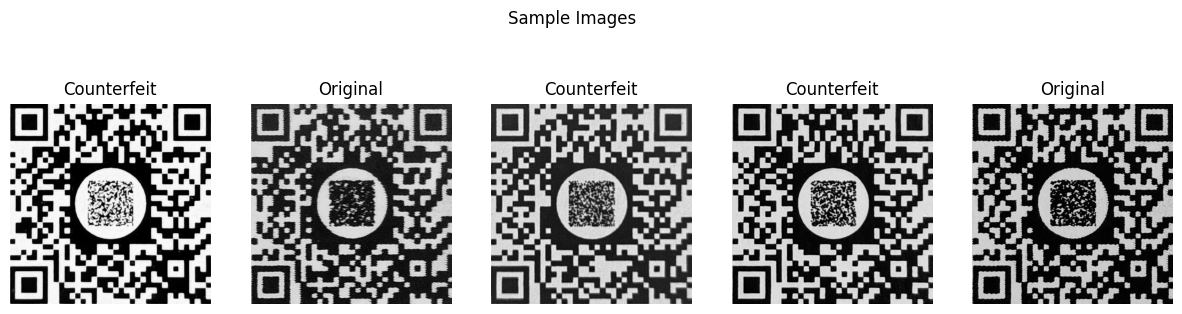

In [5]:
def show_samples(X, y, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 4))
    fig.suptitle(title)
    for i in range(5):
        axes[i].imshow(X[i], cmap='gray')
        axes[i].set_title("Original" if y[i]==0 else "Counterfeit")
        axes[i].axis('off')
    plt.show()

show_samples(X_train, y_train, "Sample Images")


In [6]:
def extract_global_features(img):
    hist = cv2.calcHist([img], [0], None, [256], [0, 256]).flatten()
    edges = cv2.Canny(img, 100, 200)
    edge_hist = np.histogram(edges, bins=2)[0]
    return np.concatenate([hist, edge_hist])


In [11]:
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

def extract_lbp_features(img, P=8, R=1):
    lbp = local_binary_pattern(img, P, R, method="uniform")
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, P + 3), range=(0, P + 2))
    return hist / np.sum(hist)

def extract_glcm_features(img):
    glcm = graycomatrix(img, [1], [0], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    return np.array([contrast, correlation, energy, homogeneity])


In [12]:
def extract_features(img):
    return np.concatenate([
        extract_global_features(img),
        extract_lbp_features(img),
        extract_glcm_features(img)
    ])

X_train_feat = np.array([extract_features(img) for img in X_train])
X_test_feat = np.array([extract_features(img) for img in X_test])


In [13]:
svm = SVC(kernel='rbf', C=1, gamma='scale')
svm.fit(X_train_feat, y_train)
y_pred_svm = svm.predict(X_test_feat)
print("SVM Results:\n", classification_report(y_test, y_pred_svm))


SVM Results:
               precision    recall  f1-score   support

           0       0.88      0.29      0.44        24
           1       0.47      0.94      0.62        16

    accuracy                           0.55        40
   macro avg       0.67      0.61      0.53        40
weighted avg       0.71      0.55      0.51        40



In [14]:
rf = RandomForestClassifier(n_estimators=100)
rf.fit(X_train_feat, y_train)
y_pred_rf = rf.predict(X_test_feat)
print("Random Forest Results:\n", classification_report(y_test, y_pred_rf))


Random Forest Results:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98        24
           1       1.00      0.94      0.97        16

    accuracy                           0.97        40
   macro avg       0.98      0.97      0.97        40
weighted avg       0.98      0.97      0.97        40



In [16]:
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_feat, y_train)
y_pred_lr = lr.predict(X_test_feat)
print("Logistic Regression Results:\n", classification_report(y_test, y_pred_lr))


Logistic Regression Results:
               precision    recall  f1-score   support

           0       0.96      0.92      0.94        24
           1       0.88      0.94      0.91        16

    accuracy                           0.93        40
   macro avg       0.92      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



In [17]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train_feat, y_train)
y_pred_knn = knn.predict(X_test_feat)
print("K-Nearest Neighbors Results:\n", classification_report(y_test, y_pred_knn))


K-Nearest Neighbors Results:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82        24
           1       0.73      0.69      0.71        16

    accuracy                           0.78        40
   macro avg       0.77      0.76      0.76        40
weighted avg       0.77      0.78      0.77        40



In [18]:
gb = GradientBoostingClassifier(n_estimators=100)
gb.fit(X_train_feat, y_train)
y_pred_gb = gb.predict(X_test_feat)
print("Gradient Boosting Results:\n", classification_report(y_test, y_pred_gb))


Gradient Boosting Results:
               precision    recall  f1-score   support

           0       0.92      0.96      0.94        24
           1       0.93      0.88      0.90        16

    accuracy                           0.93        40
   macro avg       0.93      0.92      0.92        40
weighted avg       0.93      0.93      0.92        40



In [19]:
models = {
    "SVM": svm,
    "Random Forest": rf,
    "Logistic Regression": lr,
    "KNN": knn,
    "Gradient Boosting": gb
}

for name, model in models.items():
    acc = accuracy_score(y_test, model.predict(X_test_feat))
    print(f"{name}: Accuracy = {acc:.2f}")


SVM: Accuracy = 0.55
Random Forest: Accuracy = 0.97
Logistic Regression: Accuracy = 0.93
KNN: Accuracy = 0.78
Gradient Boosting: Accuracy = 0.93


In [21]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [22]:
IMG_SIZE = 128  # Standard size for all images

def load_images(folder, label):
    images = []
    for filename in os.listdir(folder):
        path = os.path.join(folder, filename)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            images.append((img, label))
    return images

# Load both classes
original = load_images(r"C:\Users\dell\Downloads\Second Print-20250320T105625Z-001\Second Print", 0)
counterfeit = load_images(r"C:\Users\dell\Downloads\First Print-20250320T104202Z-001\First Print", 1)

# Combine and shuffle
all_data = original + counterfeit
np.random.shuffle(all_data)

# Separate X and y
X, y = zip(*all_data)
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1).astype('float32') / 255.0
y = to_categorical(y, num_classes=2)  # one-hot encode

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    BatchNormalization(),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')  # 2 classes: Original / Counterfeit
])


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

# Train
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=15
)


Epoch 1/15


C:\Users\dell\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 347ms/step - accuracy: 0.6028 - loss: 1.9192 - val_accuracy: 0.4250 - val_loss: 0.9188
Epoch 2/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 252ms/step - accuracy: 0.7655 - loss: 2.2868 - val_accuracy: 0.4250 - val_loss: 0.8410
Epoch 3/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.8259 - loss: 0.8825 - val_accuracy: 0.4500 - val_loss: 0.6420
Epoch 4/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.8844 - loss: 0.8878 - val_accuracy: 0.5750 - val_loss: 0.6188
Epoch 5/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 232ms/step - accuracy: 0.8904 - loss: 0.6345 - val_accuracy: 0.5750 - val_loss: 0.8082
Epoch 6/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 238ms/step - accuracy: 0.8738 - loss: 0.9171 - val_accuracy: 0.5750 - val_loss: 0.7759
Epoch 7/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 233ms/step - accuracy: 0.8563 - loss: 0.8922 - val_accuracy: 0.5750 - val_loss: 1.0520
Epoch 8/15
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 249ms/step - accuracy: 0.9011 - loss: 0.3704 - val_accuracy: 0.5750 - val_loss: 1.1345
Epo

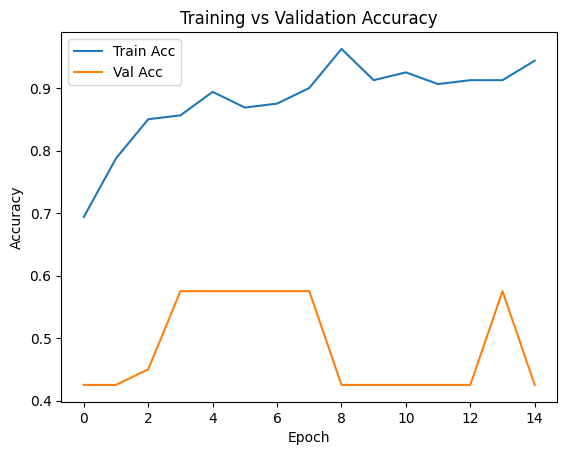

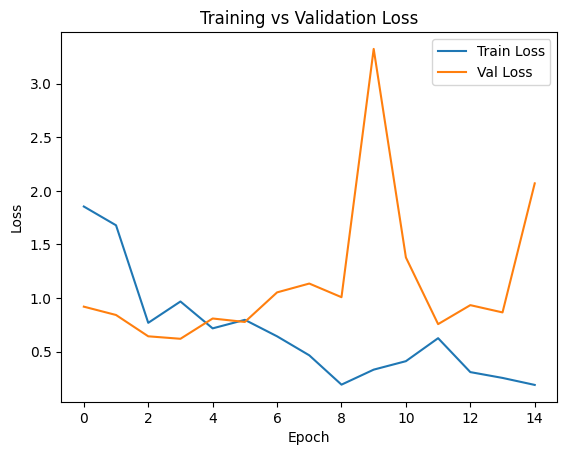

In [25]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()


In [26]:
loss, acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc:.2f}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4396 - loss: 2.0233
Test Accuracy: 0.43


In [27]:
# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred))



2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        23
           1       0.42      1.00      0.60        17

    accuracy                           0.42        40
   macro avg       0.21      0.50      0.30        40
weighted avg       0.18      0.42      0.25        40



C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
